In [25]:
%load_ext autoreload
%autoreload 2

import os
import utils
from image_search import *
from spatial_verification import *
import scipy.io
import PIL.Image
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
num_words = 10001  # 10000 + 1 because we use 0 for sparse_matrices
data = scipy.io.loadmat('data/mpvdb_haff2.mat')
visual_words = np.array([x[0] for x in data['VW'][0]])
img_names = np.array([x[0] for x in data['NAMES'][0]])

# information about each point is in a form of [x, y, a11, a12, a21, a22]
geometries = np.array([x.T for x in data['GEOM'][0]])
idf = get_idf(visual_words, num_words)
DB  = create_db_tfidf(visual_words, num_words, idf)

options = {
        'max_tc': 600,
        'max_MxN': 10,
        'max_spatial': 50,
        'inlier_threshold': 8,
        'data_root_dir': 'data/',
        'minimum_score': 0.0,
        'use_query_expansion': False,
        'max_qe_keypoints': 1500,
        'min_inliers_for_qe': 10
}

figsize=(13, 13)

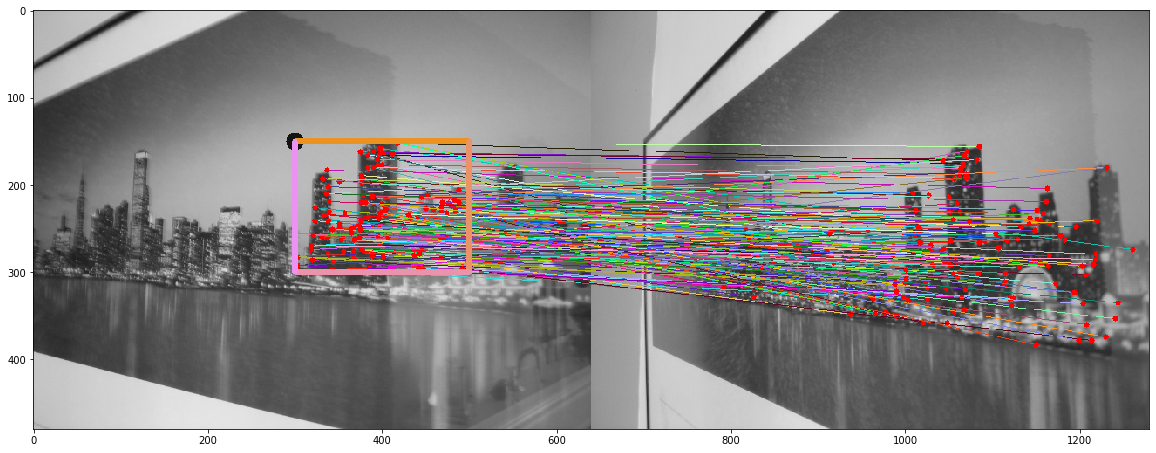

Tentative correspondences: 189
	[290 512]
	[185 947]
	[ 91 183]
	[ 30 853]
	[ 264 1241]
	[121 132]
	[132 828]
	[ 268 1027]
	[ 274 1346]
	[228 794]
#inliers: 67.0
A: [[ 9.08590236e-01  2.63316450e-02  6.49955214e+01]
 [-1.35187133e-02  1.18612329e+00 -1.78351652e+01]
 [ 0.00000000e+00 -0.00000000e+00  1.00000000e+00]]


In [27]:
q_id = 430
d_id = 433
bbox_xyxy = [300, 150, 500, 300]

img1 = PIL.Image.open(os.path.join(options['data_root_dir'], img_names[q_id]))
img2 = PIL.Image.open(os.path.join(options['data_root_dir'], img_names[d_id]))

q_idxs = utils.get_pts_in_box(geometries[q_id], bbox_xyxy)
correspondencies = get_tentative_correspondencies(
    visual_words[q_id][q_idxs], visual_words, [d_id], 
    options['max_tc'], options['max_MxN']
) 
corr=correspondencies[0]

q_geom = geometries[q_id][q_idxs.reshape(-1)]
d_geom = geometries[d_id]
im_visu = utils.draw_tentative_correspondencies(
    img1, q_geom, img2, d_geom, corr
)

im_visu = utils.draw_bbox(im_visu, bbox_xyxy)
plt.figure(figsize=(20, 10))
plt.imshow(im_visu)
plt.show()

print('Tentative correspondences: {}'.format(len(corr)))
for c in corr[:10]:
    print('\t{}'.format(c))

As, scores = ransac_affine(q_geom, geometries, correspondencies, [d_id], options['inlier_threshold'])
print("#inliers: {}".format(scores[0]))
print("A: {}".format(As[0]))

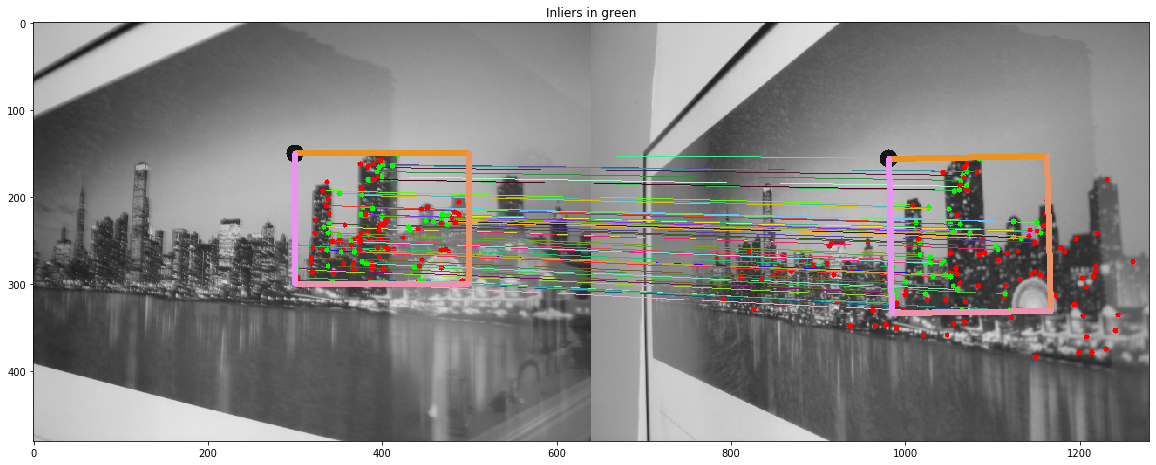

inliers pairs: [[ 121  132]
 [ 132  828]
 [ 274 1346]
 [ 193  988]
 [ 163  778]
 [ 198 1136]
 [ 201  995]
 [ 271 1337]
 [  84  311]
 [ 138  244]]...


In [28]:
q_pts = np.hstack((q_geom[:, :2], np.ones((q_geom.shape[0], 1))))
q_pts_transformed = np.dot(As[0], q_pts.T).T

dists = np.linalg.norm(q_pts_transformed[corr[:, 0], :2] - d_geom[corr[:, 1], :2], axis=1)
inliers = dists <= options['inlier_threshold']

im_visu = utils.draw_tentative_correspondencies(img1, q_geom, img2, d_geom, corr, inliers, draw_outliers_line=False)
im_visu = utils.draw_bbox(im_visu, bbox_xyxy)
im_visu = utils.draw_bbox(im_visu, bbox_xyxy, As[0], [img1.size[0], 0])

plt.figure(figsize=(20, 10))
plt.imshow(im_visu)
plt.title('Inliers in green')
plt.show()

print("inliers pairs: {}...".format(corr[inliers][:10])) 

computed in: 11.716s


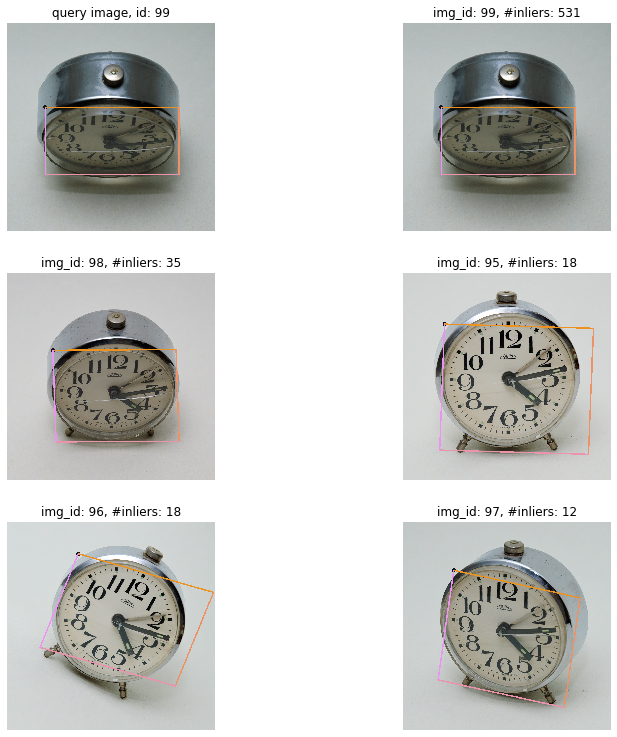

In [34]:
# Wake up
q_id = 99
bbox_xyxy = [188, 415, 846, 745]
utils.query_and_visu(q_id, visual_words, geometries, bbox_xyxy, DB, idf, options, img_names, figsize=figsize)

computed in: 4.798s


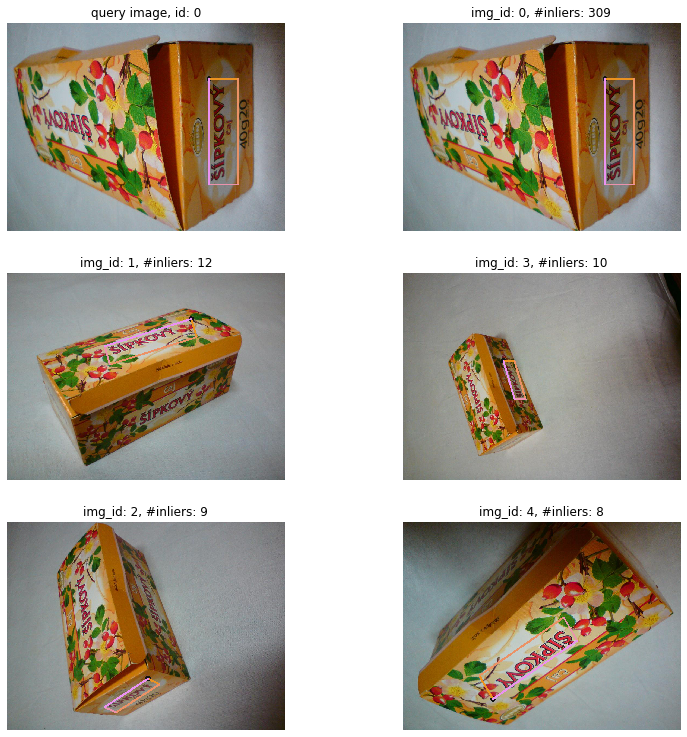

In [35]:
# Would you like some tea?
q_id = 0
bbox_xyxy = [744, 206, 850, 596]
utils.query_and_visu(q_id, visual_words, geometries, bbox_xyxy, DB, idf, options, img_names, figsize=figsize)

computed in: 0.393s


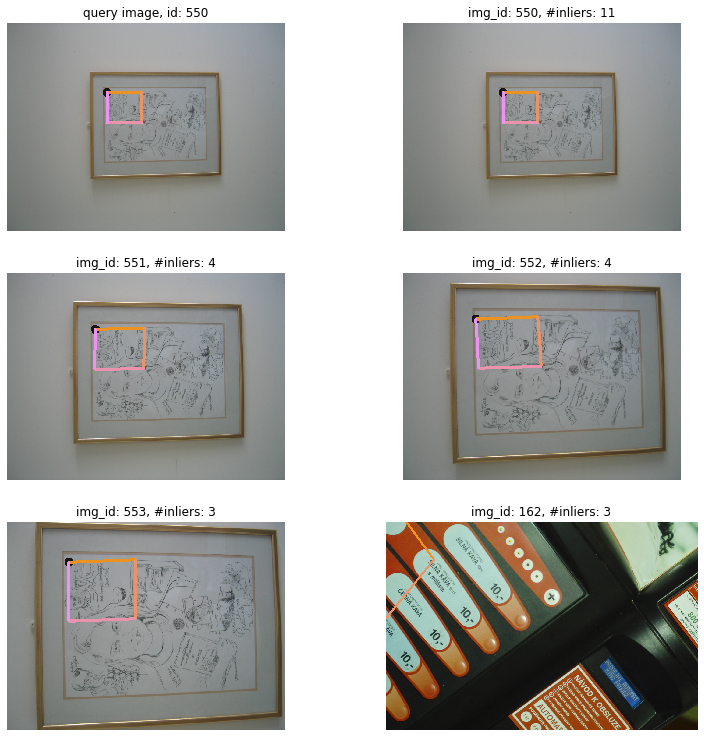

In [36]:
# art1
q_id = 550
bbox_xyxy = [230, 160, 310, 230]
utils.query_and_visu(q_id, visual_words, geometries, bbox_xyxy, DB, idf, options.copy(), img_names, figsize=figsize)


computed in: 1.583s


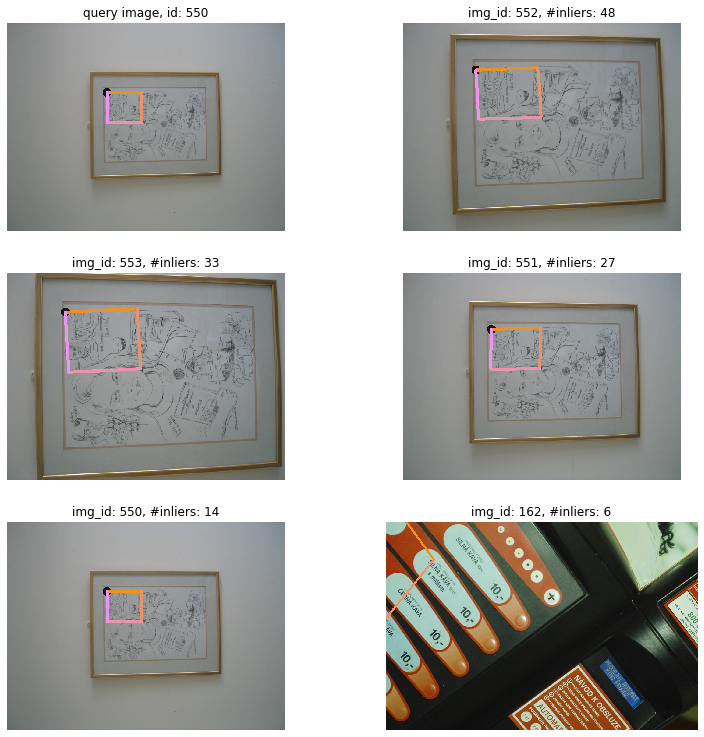

In [37]:
# art1 with query expansion
q_id = 550
bbox_xyxy = [230, 160, 310, 230]
options['use_query_expansion'] = True
options['min_inliers_for_qe'] = 4
utils.query_and_visu(q_id, visual_words, geometries, bbox_xyxy, DB, idf, options.copy(), img_names, figsize=figsize)
options['use_query_expansion'] = False
options['min_inliers_for_qe'] = 10

In [38]:
print("Results will be checkend manualy!")

Results will be checkend manualy!
